### Assignment 4

#### Submit your assignment as .ipynb

#### Exercise 1.

Write a function

In [2]:
def MyFirstDeriv(f, x0, h):
    def fun_1(h):
        return (f(x0+h)-f(x0-h))/(2*h)
    return (4*fun_1(h)-fun_1(2*h))/3

In [3]:
def f(x):
    return 5*x**2+9
a=MyFirstDeriv(f,x0=1,h=1e-5)
b=MyFirstDeriv(f,x0=1,h=0.5*1e-5)
print("h:",a,"\th/2:",b)

h: 10.000000000095119 	h/2: 9.999999999947088


to compute the derivative $f'(x_0)$ of the function $f$ of an unknown form, using Richardson extrapolation with the central difference g(h) and the step sizes $h$ and $\displaystyle \frac{h}{2}$.
Conduct some simple test cases for the function.


#### Exercise 2.

This exercise considers a smoothed version of binomial tree pricer for American put options.
Unlike the standard binomial tree pricer that evaluates the payoff function at the final time step,
we can skip the final time step payoff evaluation, but start from the second last time step by applying Black-Scholes analytic formula for European put option to calculate the continuation value.
This is because the American early exercise feature vanishes at the last time step. So at the second time step, if the option holder decides not to exercise, he/she has left with a European option with time to expiry equal to the time interval $\Delta t$.
Note that you still need to update the node's value using maximum of continuation value and exercise value at the second last step.
Compared with the standard tree pricer where the final time slice is a non-differentiable function at the strike,
the smooth Black-Scholes analytic formula would help stablizing the risk sensitivities.

Implement the function

In [4]:
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0
def bsPrice(S, r, v, T, K):
    fwd = S * math.exp(r * T)
    stdev = v * math.sqrt(T)
    d1 = math.log(fwd / K) / stdev + stdev / 2
    d2 = d1 - stdev
    return math.exp(-r * T) * (K * cnorm(-d2) - cnorm(-d1) * fwd)

In [5]:
def amerPutSmooth(S, T, v, r, n, K):
    t = T / n
    b = math.exp(v * v * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    #vs = [bsPrice(S*u**(n-i-i), r, v, t, K) for i in range(n+1)]
    vs = [max((K - S * u**(n-i-i)),0) for i in range(n+1)]
    for j in range(n):
        nodeS = S * u**(n-1-j-j)
        continuation = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
        if max(K-nodeS,0)<=continuation:    
            vs[j] = bsPrice(S*u**(n-1-j-j), r, v, t, K)
        else:
            vs[j]=max(K-nodeS,0)
    for i in range(n-2, -1, -1):
        for j in range(i+1):
            nodeS = S * u**(i-j-j)
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
            vs[j] = max(max((K - nodeS),0),continuation)
    return vs[0]

In [6]:
def amerPutStandard(S, T, v, r, n, K):
    t = T / n
    b = math.exp(v * v * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    vs = [max((K - S * u**(n-i-i)),0) for i in range(n+1)]
    for i in range(n-1, -1, -1):
        for j in range(i+1):
            nodeS = S * u**(i-j-j)
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
            vs[j] = max(max((K - nodeS),0),continuation)
    return vs[0]

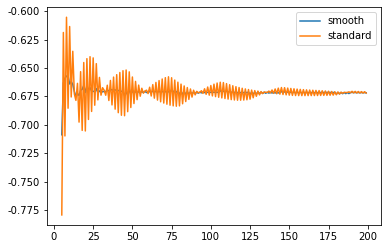

In [7]:
#1)
import math
import matplotlib.pyplot as plt
S,K,T,v,r=100,108,1,0.15,0.03
N=range(5,200)
Delta_smooth=[]
for n in N:
    def testamputsmooth(S):
        return amerPutSmooth(S, T, v, r, n, K)
    delta=MyFirstDeriv(testamputsmooth, 100, 1)
    Delta_smooth.append(delta)
    
Delta_standard=[]
for n in N:
    def testamputstandard(S):
        return amerPutStandard(S, T, v, r, n, K)
    delta=MyFirstDeriv(testamputstandard, 100, 1)
    Delta_standard.append(delta)
plt.rcParams['axes.unicode_minus'] = False
plt.plot(N,Delta_smooth,label="smooth")
plt.plot(N,Delta_standard,label="standard")
plt.legend()

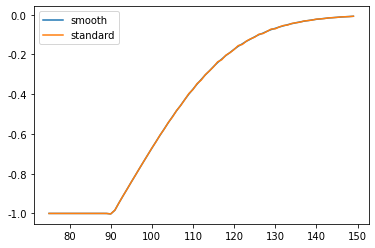

In [8]:
#2)
n,K,T,v,r=200,108,1,0.15,0.03
S=range(75,150)
Delta_smooth=[]
def testamputsmooth(S):
    return amerPutSmooth(S, T, v, r, n, K)
for s in S:
    delta=MyFirstDeriv(testamputsmooth, s, 1)
    Delta_smooth.append(delta)

Delta_standard=[]
def testamputstandard(S):
    return amerPutStandard(S, T, v, r, n, K)
for s in S:    
    delta=MyFirstDeriv(testamputstandard, s, 1)
    Delta_standard.append(delta)
plt.plot(S,Delta_smooth,label="smooth")
plt.plot(S,Delta_standard,label="standard")
plt.legend()

to explore this method with CRR binomial model. Conduct two test cases:

1) Plot the option's delta (using MyFirstDeriv implemented in Exercise 1 with step size $h$ set to 1 dollar)
for $n$ from 5 to 200, for both the smoothed version of the pricer and the standard American put option pricer given in the example code,
with $S = 100, K = 108, T = 1, v = 15\%, r = 3\%$.

2) Plot the option's delta
for $S$ from 75 to 150, for both the smoothed version of the pricer and the standard American put option pricer given in the example code,
with $n = 200, K = 108, T = 1, v = 15\%, r = 3\%$.

#### Exercise 3.

A double no touch option has two barrier levels: upBarrier and downBarrier.
When the stock price touches one of the barriers the option is terminated.
If the barriers are not touched until the option expiry date, the option pays 1 dollar.

Implement a double no touch option pricer in PDE with Crank-Nicolson scheme.

In [9]:
import numpy as np

def dntPDEPricer(S, T, r, q, v, upBarrier, downBarrier, nT, nS):
    mu = r - q
    srange = 5 * v * math.sqrt(T)
    maxS = S * math.exp((mu - v * v * 0.5)*T + srange)
    minS = S * math.exp((mu - v * v * 0.5)*T - srange)
    dt = T / (nT-1)
    ds = (maxS - minS) / (nS-1)
    sGrid = np.array([minS + i*ds for i in range(nS)])
    def payoff(s):
        if s >= upBarrier or s <=downBarrier:
            x = 0
        else:
            x = 1
        return x
    ps = np.array([payoff(s) for s in sGrid])
    a, b = mu/2.0/ds, v * v / ds / ds    
    M = np.zeros((nS, nS))
    D = np.zeros((nS, nS))    
    for i in range (1, nS-1):
        M[i, i-1] = a*sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        M[i, i] = r + b * sGrid[i] * sGrid[i]
        M[i, i+1] = -a * sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        D[i,i] = 1.0
    M[0,0], M[nS-1, nS-1] = 1.0, 1.0
    w = 0.5
    rhsM = (D - dt * M) * w + (1-w) * np.identity(nS)
    lhsM = w * np.identity(nS) + (D + dt * M) * (1-w)
    inv = np.linalg.inv(lhsM)
    for j in range(1, nT):
        ps = rhsM.dot(ps)
        ps[0] = dt*math.exp(-r*j*dt) * payoff(sGrid[0]) 
        ps[nS-1] = dt*math.exp(-r*j*dt) * payoff(sGrid[nS-1])
        ps = inv.dot(ps)
    return np.interp(S, sGrid, ps)

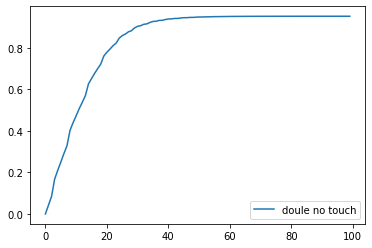

In [10]:
S,T,v,r,q,nT,nS = 100, 1, 0.15, 0.05, 0.03, 100, 100
def Doublenotouch(x):
    upBarrier = 100+x
    downBarrier = 100-x
    return dntPDEPricer(S, T, r, q, v, upBarrier, downBarrier, nT, nS)
X = range(100)
price=[]
for x in X:
    pc=Doublenotouch(x)
    price.append(pc)
plt.plot(X,price,label="doule no touch")
plt.legend()

In [11]:
a = Doublenotouch(100)
print("The price converges to",a)

The price converges to 0.9512253380050055


When the spot is beyond the up and down barriers the option worths 0,
so we can set the boundaries of the S grid at exactly the up and down barrier levels, and use Dirichlet boundary condition.

For $S_0 = 100, T = 1, \sigma = 15\%, r = 5\%, q = 3\%, nT = 100, nS = 100$,
plot the double no touch price as a function of x which determines the barrier levels: upBarrier = 100+x, downBarrier = 100-x. What should be the price converges to when x is large enough?
Verify that is the case in the plot.


#### Exercise 4.

a) Write a ODE solver using Euler explicit method:

In [12]:
def eulerODEExplicit(f, x0, y0, n, x):
    h = (x-x0)/n
    for i in range(n):
        y0 += f(x0,y0)*h
        x0 += h
    return y0

The function returns the value $y$ at the given $x$ by solveing the ODE:
\begin{align}
y' = f(x,y)
\end{align}
with initial value $(x_0, y_0)$ and number of time steps $n$.

b) Write a ODE solver using Euler implicit method:

In [13]:
def eulerODEImplicit(f, x0, y0, n, x):
    h = (x-x0)/n
    for i in range(n):
        y0 = y0/(1+3*h)
    return y0

c) And Crank-Nicholson:

In [14]:
def eulerODECrankN(f, x0, y0, n, x):
    h = (x-x0)/n
    for i in range(n):
        y0 += h*f(x0+h/2,y0+h/2*f(x0,y0))
        x0 += h
    return y0

d) Test the three solvers with the ODE:
\begin{align}
y' = -3y
\end{align}
using initial point x0 = 0, y0 = 1, solve $y$ for $x$ from $[-15, -14, \ldots, 15]$ with a reasonable choice of $n$.
Print out the errors of the solver for each $x$ (note that the error is not necessarily small for all $x$ and all methods, explain the source of errors for the cases the error is obviously not small).

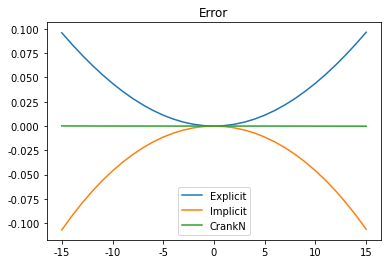

In [15]:
x0,y0,n=0,1,10000
def f(x,y):
    return -3*y
X = range(-15,16)
err_exp=[]
err_imp=[]
err_cra=[]
for x in X:
    y_correct = math.exp(-3*x)
    y_exp = eulerODEExplicit(f, x0, y0, n, x)
    y_imp = eulerODEImplicit(f, x0, y0, n, x)
    y_cra = eulerODECrankN(f, x0, y0, n, x)
    err_exp.append((y_correct-y_exp)/y_correct)
    err_imp.append((y_correct-y_imp)/y_correct)
    err_cra.append((y_correct-y_cra)/y_correct)
plt.title("Error")
plt.plot(X,err_exp,label="Explicit")
plt.plot(X,err_imp,label="Implicit")
plt.plot(X,err_cra,label="CrankN")
plt.legend()

When the absolute value of x is very large, it will lead to a large h, which will lead to a large error, and the accuracy of explicit and implicit is first-order, and the accuracy of CrankN is third-order, so Euler implicit and explicit scheme will lead to bigger truncation error. 